In [14]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "black" # 21st_year, pieman, slumlordreach, black

MODEL = 'bert-base-uncased' 
# BERT: bert-base-uncased, bert-large-uncased
# GPT: gpt2, gpt2-xl, gpt-neo-2.7B

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/black/tr_tokens.csv
Loaded 534 TRs.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Produce Layerwise Activations / Z-Reps

In [15]:
foo.process_stimulus_activations()

Processing TR 0.

TR 0: Window Stimulus: So I
	 TR stimulus: ['so', 'i']
Processing TR 100.

TR 100: Window Stimulus: market I had ever been in I was excited and I was nervous and so I am trying to get to know the community And so I'm going to every fundraiser and every event I can think of and after one of those events I promise you it was actually here at the Sheldon in St Louis Missouri a young man approached me outside on the sidewalk He was black and he said to me
	 TR stimulus: ['he', 'said', 'to', 'me']
Processing TR 200.

TR 200: Window Stimulus: know They got to know now Debate put to a rest So I am now all about town and people are beginning to recognize me just from my voice I'm at the grocery store I'm chasing my kids at the St Louis zoo yelling at them people are recognizing my voice I'm gonna drop another hint on the air I'm enjoying the secret mission And so I described trying to make my mother's
	 TR stimulus: ['make', 'my', 'mother', "'", 's']
Processing TR 300.

TR 30

In [16]:
foo.model_name

'bert-base-uncased'

In [17]:
SAVE_QKV_VECTORS = False

for layer in range(0, 12):

    layer_activations = foo.layer_activations_from_tensor(foo.stimulus_df["activations"], layer)
    layer_mean_embeddings = np.array([l.mean(0).numpy() for l in layer_activations])
    np.save("{}_{}_layer_{}_activations.npy".format(STIMULUS, MODEL, layer), layer_mean_embeddings)
    
    print(layer_mean_embeddings.shape)
    
    layer_z_reps = foo.layer_activations_from_tensor(foo.stimulus_df["z_reps"], layer)
    layer_mean_z_reps = np.array([l.mean(0).numpy() for l in layer_z_reps])
    np.save("{}_{}_layer_{}_z_representations.npy".format(STIMULUS, MODEL, layer), layer_mean_z_reps)
    
    print(layer_mean_z_reps.shape)

    if SAVE_QKV_VECTORS: 
        for representation in ["query", "key", "value"]:
            all_reps = foo.layer_activations_from_tensor(foo.stimulus_df["query"], layer)
            mean_rep = np.array([l.mean(0).numpy() for l in all_reps])
            np.save("{}_{}_layer_{}_{}.npy".format(STIMULUS, MODEL, layer, representation), mean_rep)
            print("Processed {} layer {} --> {}.".format(representation, layer, mean_rep.shape))

layer_glove = foo.layer_activations_from_tensor(foo.stimulus_df["glove"], 0)
np.save("{}_{}_layer_{}_glove.npy".format(STIMULUS, MODEL, 0), layer_glove)
#     df["layer_{}".format(layer)] = layer_mean_embeddings

(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)


In [19]:
ALL_LAYER_REPS = "scp {}_{}_layer_*_activations.npy {}_{}_layer_*_z_representations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/raw_embeddings"

print("SCP all model layers and z-reps to PNI:\n")

print(ALL_LAYER_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL, STIMULUS, MODEL))

SCP all model layers and z-reps to PNI:

scp black_bert-base-uncased_layer_*_activations.npy black_bert-base-uncased_layer_*_z_representations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/bert-base-uncased/raw_embeddings


# Produce Attention Vectors
Important question: how many prior tokens should we take for attention metric context?

count    534.000000
mean       3.181648
std        2.051577
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       11.000000
Name: n_transformer_tokens_in_tr, dtype: float64


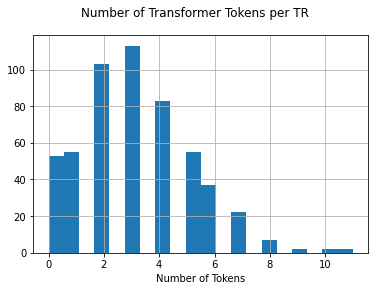

In [20]:
print(foo.stimulus_df.n_transformer_tokens_in_tr.describe())
foo.stimulus_df.n_transformer_tokens_in_tr.hist(bins=20);
plt.suptitle("Number of Transformer Tokens per TR")
plt.xlabel("Number of Tokens");

In [21]:
# Median number of tokens per TR is 5; 75th percentile is 7.
# Assuming we're using about 30 seconds of prior context, that's 20 TRs, so we should take 100-140 context tokens. (yikes-- we've been doing 20!)

N_ATTENTION_TOKENS = 128 # 10, 20, 128

In [23]:
foo.verbose = False
foo.process_stimulus_attentions(num_window_tokens=N_ATTENTION_TOKENS)

Processing TR 0
Processing TR 100


Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


Processing TR 200
Processing TR 300
Processing TR 400
Processing TR 500


In [24]:
print("Successfully produced attention maps for {} of {} TRs.".format( 
    len(foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]), len(foo.stimulus_df)))

Successfully produced attention maps for 495 of 534 TRs.


In [25]:
has_attentions = foo.stimulus_df[foo.stimulus_df.attentions.isnull()]
failed_attentions = foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]

## Mask Attention to produce vectors

All of the below analyses can / should be run with various parameter settings.

They run much faster than the original activation / attention code and do various masking and summarization procedures on the raw data.

In [42]:
BACKWARD_ATTENTION = True

if BACKWARD_ATTENTION:
    ATTENTION_DIRECTION = "bck"
else:
    ATTENTION_DIRECTION = "fwd"

In [43]:
foo.mask_non_tr_attentions(include_forwards=not BACKWARD_ATTENTION, 
                           include_backwards=BACKWARD_ATTENTION)

In [44]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p='inf')

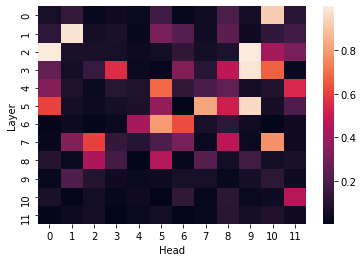

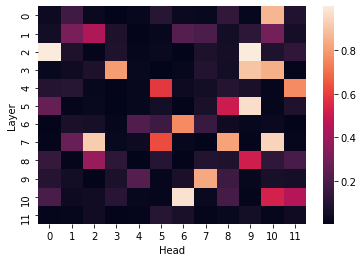

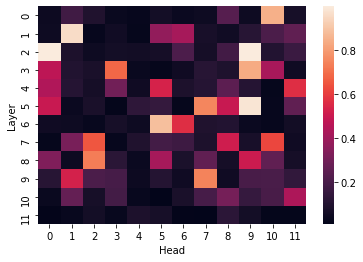

In [45]:
for x in [90, 150, 200]:
    plt.figure()
    sns.heatmap(foo.stimulus_df.attention_heads_Linf.iloc[x])
    plt.xlabel("Head")
    plt.ylabel("Layer")

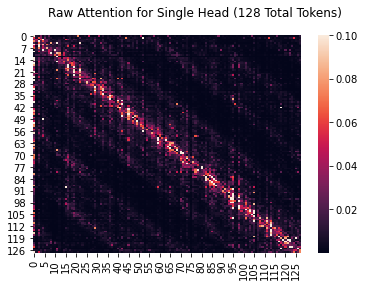

In [46]:
sns.heatmap(foo.stimulus_df.attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("Raw Attention for Single Head ({} Total Tokens)".format(N_ATTENTION_TOKENS));

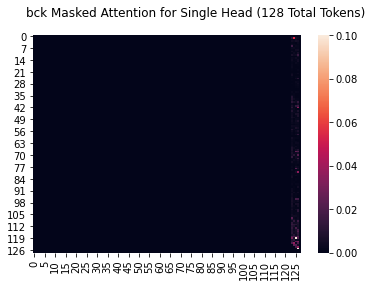

In [47]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("{} Masked Attention for Single Head ({} Total Tokens)".format(ATTENTION_DIRECTION, N_ATTENTION_TOKENS));

## Output Attention Vector .npy's

In [48]:
import itertools

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

In [49]:
for p in ['inf']:  # can also do p=1 or 2, but not using those currently.

    COMPLEXITY_OUTPUT_FILE = "{}_{}_syntactic_complexity_L-{}_T-{}_D-{}.npy".format(STIMULUS, MODEL, p, N_ATTENTION_TOKENS, ATTENTION_DIRECTION)
    print("Outputting metrics to {}".format(COMPLEXITY_OUTPUT_FILE))

    attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))

    attention_np_arrays = np.array(attention_vectors)
    print(attention_np_arrays.shape)
    np.save(COMPLEXITY_OUTPUT_FILE, attention_np_arrays)

Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-1_T-128_D-bck.npy
(534,)
Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-bck.npy
(534,)


In [50]:
import random

def concatenate_fwd_bck_arrays(fwd, bck):

    res = []
    for f, b in zip(fwd, bck):
        if f is None and b is None:
            res.append(None)
        else:                
            res.append(f + b)
    res = np.array(res, dtype=object)
        
    return res

In [51]:
import glob

backwards_metrics = [f for f in glob.glob("*.npy") if 'bck' in f]

for backwards_file in backwards_metrics:
    
    bck = np.load(backwards_file, allow_pickle=True)
    forward_file = backwards_file.replace("bck", "fwd")
    fwd = np.load(forward_file, allow_pickle=True)
    
    concat = concatenate_fwd_bck_arrays(fwd, bck)
    concat_file = backwards_file.replace("bck", "concat")
    
    np.save(concat_file, concat)
    
    print(concat.shape)
    print(len(concat[-10]))
    print(backwards_file + "\n" + forward_file + "\n" + concat_file + "\n=======")

    

(534,)
288
black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-bck.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-fwd.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat.npy
(534,)
288
black_bert-base-uncased_syntactic_complexity_L-1_T-128_D-bck.npy
black_bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd.npy
black_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy


## SCP to PNI
```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [ ]:
ALL_SYNTAX_REPS = "scp {}_{}_syntactic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"

print("SCP all syntactic representations to PNI:\n")
print(ALL_SYNTAX_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL, STIMULUS, MODEL))

# DEMO: attention distance masking
Just in case I want to double check this logic sometime.

In [ ]:
import numpy as np
N_TOKENS = 5
a = np.array(range(1,N_TOKENS+1))
columns = np.tile(a,(N_TOKENS,1))
rows = np.tile(a,(N_TOKENS,1)).T
abs((rows-columns))